Danny Hong 
ECE-411 Problem Set 1: Portfolios

For this assignment, two groups of five stocks from two different sectors were used. The two sectors were the Tech Sector and the Bank Sector. Below are the stocks from each sector:

Tech Sector Stocks: TWTR, AAPL, MSFT, AMZN, GOOG

Bank Sector Stocks: JPM, BAC, WFC, MS, GS



In [16]:
!pip install yfinance
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import scipy.optimize as optimize
import math
from prettytable import PrettyTable
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Data Acquisition and Pre-Processing

In [17]:
start = datetime(year = 2017, month = 12, day = 31)
end = datetime(year = 2018, month = 12, day = 31)

tech_stocks = ['TWTR', 'AAPL', 'MSFT', 'AMZN', 'GOOG']
bank_stocks = ['JPM', 'BAC', 'WFC', 'MS', 'GS']
combined_stocks = tech_stocks + bank_stocks
SP500 = '^GSPC'

tech_stock_returns = []
bank_stock_returns = []

for i in range(len(tech_stocks)):
    print(tech_stocks[i])
    tech_stock_price = yf.download(tech_stocks[i], start, end)['Adj Close']
    tech_stock_returns.append(tech_stock_price.pct_change().dropna().to_frame('Daily Returns'))
    
for j in range(len(bank_stocks)):
    print(bank_stocks[j])
    bank_stock_price = yf.download(bank_stocks[j], start, end)['Adj Close']
    bank_stock_returns.append(bank_stock_price.pct_change().dropna().to_frame('Daily Returns'))

print(SP500)
SP500_stock_price = yf.download(SP500, start, end)['Adj Close']
SP500_stock_return = (SP500_stock_price.pct_change().dropna().to_frame('Daily Returns'))

TWTR
[*********************100%***********************]  1 of 1 completed
AAPL
[*********************100%***********************]  1 of 1 completed
MSFT
[*********************100%***********************]  1 of 1 completed
AMZN
[*********************100%***********************]  1 of 1 completed
GOOG
[*********************100%***********************]  1 of 1 completed
JPM
[*********************100%***********************]  1 of 1 completed
BAC
[*********************100%***********************]  1 of 1 completed
WFC
[*********************100%***********************]  1 of 1 completed
MS
[*********************100%***********************]  1 of 1 completed
GS
[*********************100%***********************]  1 of 1 completed
^GSPC
[*********************100%***********************]  1 of 1 completed


In [18]:
fed_data = web.DataReader(['TB3SMFFM', 'FEDFUNDS'], 'fred', start, end)
fed_data['3MO T-BILL'] = fed_data['TB3SMFFM'] + fed_data['FEDFUNDS']
fed_3mo_daily = (fed_data['3MO T-BILL'].resample(rule = 'B').ffill().to_frame())/(100 * 252)
display(fed_3mo_daily)

,3MO T-BILL
DATE,
2018-01-01,0.000056
2018-01-02,0.000056
2018-01-03,0.000056
2018-01-04,0.000056
2018-01-05,0.000056
...,...
2018-11-26,0.000092
2018-11-27,0.000092
2018-11-28,0.000092


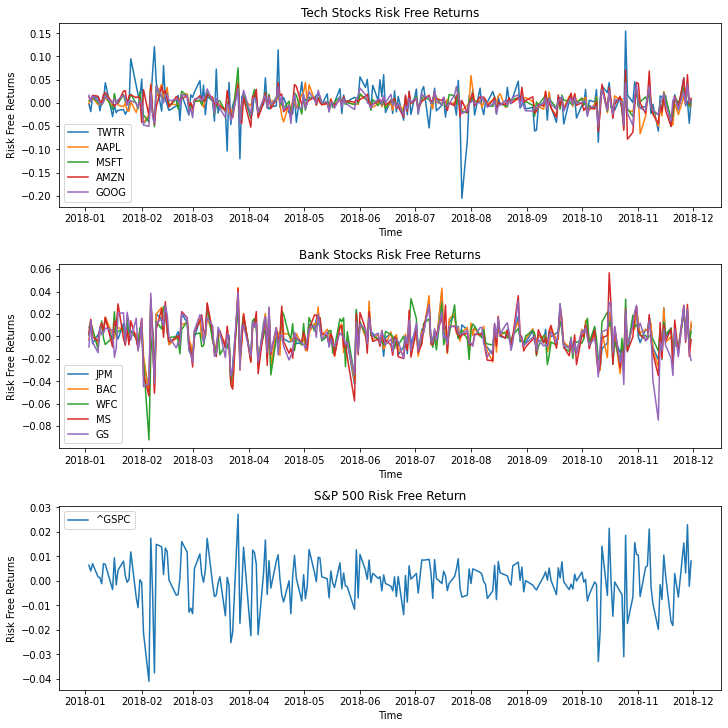

In [19]:
def subtract(stock, risk_free, name):
    stock = stock.tz_localize(None) 
    merged = risk_free.join(stock)
    subtracted = merged[name] - merged['3MO T-BILL']
    subtracted = subtracted.dropna()
    return subtracted

tech_expected_returns = []
bank_expected_returns = []
for k in range(len(tech_stock_returns)):
    tech_expected_returns.append(subtract(tech_stock_returns[k], fed_3mo_daily, 'Daily Returns'))
    bank_expected_returns.append(subtract(bank_stock_returns[k], fed_3mo_daily, 'Daily Returns'))
    
SP500_expected_returns = subtract(SP500_stock_return, fed_3mo_daily, 'Daily Returns')

#merged_stocks = []
#for l in range(len(subtracted)):
#    merged_stocks.append((pd.concat([subtracted[l], subtracted_SP], axis = 1)).dropna())

#Plotting 

fig, ax = plt.subplots(3, 1, constrained_layout = True, figsize = (10, 10))

for m in range(len(tech_expected_returns)):
    ax[0].plot(tech_expected_returns[m], label = tech_stocks[m])
    ax[1].plot(bank_expected_returns[m], label = bank_stocks[m])  

ax[2].plot(SP500_expected_returns, label = SP500)

ax[0].set_title("Tech Stocks Risk Free Returns")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Risk Free Returns")
ax[0].legend()

ax[1].set_title("Bank Stocks Risk Free Returns")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Risk Free Returns")
ax[1].legend()

ax[2].set_title("S&P 500 Risk Free Return")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Risk Free Returns")
ax[2].legend()

fig.show()

Data Analysis

In [20]:
#1a.)

SP500_sigma = SP500_expected_returns.std()
SP500_mu = SP500_expected_returns.mean()

print("S&P500 (σ, µ) point: (" + str(SP500_sigma) + ", " + str(SP500_mu) + ")")

tech_expected_returns_df = pd.DataFrame(tech_expected_returns).T
tech_expected_returns_df.columns = tech_stocks

bank_expected_returns_df = pd.DataFrame(bank_expected_returns).T
bank_expected_returns_df.columns = bank_stocks

SP500_expected_returns_df = pd.DataFrame(SP500_expected_returns)
SP500_expected_returns_df = SP500_expected_returns_df.rename(columns = {0: SP500})

all_expected_returns_df = tech_expected_returns_df.join(bank_expected_returns_df)
all_expected_returns_df = all_expected_returns_df.join(SP500_expected_returns_df)

# Calculate and display the three covariance matrices
all_covariance_matrix = all_expected_returns_df.cov()
print("\n Covariance Matrix for the full set of stocks:")
display(all_covariance_matrix)

print("\n Covariance Matrix for the tech stocks:")
tech_covariance_matrix = all_expected_returns_df[tech_stocks].cov()
display(tech_covariance_matrix)

print("\n Covariance Matrix for the bank stocks:")
bank_covariance_matrix = all_expected_returns_df[bank_stocks].cov()
display(bank_covariance_matrix)

S&P500 (σ, µ) point: (0.009777704850049326, 7.433071263165929e-05)

 Covariance Matrix for the full set of stocks:


,TWTR,AAPL,MSFT,AMZN,GOOG,JPM,BAC,WFC,MS,GS,^GSPC
TWTR,0.001257,0.000202,0.000257,0.000247,0.000272,0.000085,0.000092,0.000097,0.000130,0.000142,0.000122
AAPL,0.000202,0.000290,0.000189,0.000212,0.000190,0.000104,0.000114,0.000085,0.000137,0.000137,0.000116
MSFT,0.000257,0.000189,0.000284,0.000265,0.000236,0.000133,0.000149,0.000116,0.000168,0.000162,0.000141
AMZN,0.000247,0.000212,0.000265,0.000442,0.000260,0.000127,0.000150,0.000102,0.000173,0.000165,0.000147
GOOG,0.000272,0.000190,0.000236,0.000260,0.000294,0.000131,0.000144,0.000120,0.000172,0.000165,0.000138
JPM,0.000085,0.000104,0.000133,0.000127,0.000131,0.000181,0.000184,0.000146,0.000196,0.000167,0.000098
BAC,0.000092,0.000114,0.000149,0.000150,0.000144,0.000184,0.000214,0.000154,0.000210,0.000182,0.000105
WFC,0.000097,0.000085,0.000116,0.000102,0.000120,0.000146,0.000154,0.000202,0.000160,0.000138,0.000088
MS,0.000130,0.000137,0.000168,0.000173,0.000172,0.000196,0.000210,0.000160,0.000276,0.000219,0.000124
GS,0.000142,0.000137,0.000162,0.000165,0.000165,0.000167,0.000182,0.000138,0.000219,0.000243,0.000114



 Covariance Matrix for the tech stocks:


,TWTR,AAPL,MSFT,AMZN,GOOG
TWTR,0.001257,0.000202,0.000257,0.000247,0.000272
AAPL,0.000202,0.000290,0.000189,0.000212,0.000190
MSFT,0.000257,0.000189,0.000284,0.000265,0.000236
AMZN,0.000247,0.000212,0.000265,0.000442,0.000260
GOOG,0.000272,0.000190,0.000236,0.000260,0.000294



 Covariance Matrix for the bank stocks:


,JPM,BAC,WFC,MS,GS
JPM,0.000181,0.000184,0.000146,0.000196,0.000167
BAC,0.000184,0.000214,0.000154,0.000210,0.000182
WFC,0.000146,0.000154,0.000202,0.000160,0.000138
MS,0.000196,0.000210,0.000160,0.000276,0.000219
GS,0.000167,0.000182,0.000138,0.000219,0.000243


In [21]:
#1b.)

all_condition_number = np.linalg.cond(all_covariance_matrix)
tech_condition_number = np.linalg.cond(tech_covariance_matrix)
bank_condition_number = np.linalg.cond(bank_covariance_matrix)

print("Covariance Condition Number for all stocks: ", all_condition_number)
print("Covariance Condition Number for tech stocks: ", tech_condition_number)
print("Covariance Condition Number for bank stocks: ", bank_condition_number)

print("""\nThe covariance of each stock is positive, which indicates that there is a positive correlation between the market and the stocks. 
In other words, as the market goes up, the stocks go up as well. In addition, these stocks are all positively correlated with one 
another, indicating that in general, when the stock's respective sector goes up, the individual stock goes up as well. Lastly, the 
covariance condition number for all the stocks altogether is relatively high, while the covariance condition number for each sector 
is relatively low. This indicates that each sector individually is more stable than combining all the stocks into one group.""")

Covariance Condition Number for all stocks:  204.06499779062347
Covariance Condition Number for tech stocks:  31.2568058118862
Covariance Condition Number for bank stocks:  71.27272247209868

The covariance of each stock is positive, which indicates that there is a positive correlation between the market and the stocks. 
In other words, as the market goes up, the stocks go up as well. In addition, these stocks are all positively correlated with one 
another, indicating that in general, when the stock's respective sector goes up, the individual stock goes up as well. Lastly, the 
covariance condition number for all the stocks altogether is relatively high, while the covariance condition number for each sector 
is relatively low. This indicates that each sector individually is more stable than combining all the stocks into one group.


In [22]:
#1c.)

single_factor_returns_residuals_df = pd.DataFrame()

for stock in combined_stocks:
    beta = all_expected_returns_df[stock].cov(all_expected_returns_df[SP500]) / all_expected_returns_df[SP500].var()
    alpha = all_expected_returns_df[stock].mean() - (beta * all_expected_returns_df[SP500].mean())
    single_factor_returns_residuals_df[stock] = all_expected_returns_df[stock] - (alpha + (beta * all_expected_returns_df[SP500]))

residuals_correlation_matrix = single_factor_returns_residuals_df.cov().round(6)
print("Correlation Matrix of the Residuals from the Single Factor Return model: ")
display(residuals_correlation_matrix)

print("""\nThe correlations within each sector are positive for both the tech stocks and the bank stocks whereas the correlations between 
the two sectors are negative. In addition, there are also slightly stronger correlations in magnitude within each sector as opposed to 
between them since the magnitudes of the covariance values for within each sector is relatively larger than the magnitudes of the covariance 
values between each sector.""")

Correlation Matrix of the Residuals from the Single Factor Return model: 


,TWTR,AAPL,MSFT,AMZN,GOOG,JPM,BAC,WFC,MS,GS
TWTR,0.001100,0.000054,0.000076,0.000058,0.000095,-0.000041,-0.000043,-0.000016,-0.000029,-0.000004
AAPL,0.000054,0.000149,0.000017,0.000032,0.000022,-0.000015,-0.000014,-0.000022,-0.000013,-0.000002
MSFT,0.000076,0.000017,0.000075,0.000047,0.000031,-0.000012,-0.000007,-0.000015,-0.000015,-0.000007
AMZN,0.000058,0.000032,0.000047,0.000214,0.000046,-0.000024,-0.000012,-0.000034,-0.000018,-0.000012
GOOG,0.000095,0.000022,0.000031,0.000046,0.000094,-0.000011,-0.000008,-0.000008,-0.000007,0.000000
JPM,-0.000041,-0.000015,-0.000012,-0.000024,-0.000011,0.000080,0.000075,0.000056,0.000069,0.000049
BAC,-0.000043,-0.000014,-0.000007,-0.000012,-0.000008,0.000075,0.000098,0.000057,0.000074,0.000056
WFC,-0.000016,-0.000022,-0.000015,-0.000034,-0.000008,0.000056,0.000057,0.000120,0.000046,0.000032
MS,-0.000029,-0.000013,-0.000015,-0.000018,-0.000007,0.000069,0.000074,0.000046,0.000115,0.000071
GS,-0.000004,-0.000002,-0.000007,-0.000012,0.000000,0.000049,0.000056,0.000032,0.000071,0.000106



The correlations within each sector are positive for both the tech stocks and the bank stocks whereas the correlations between 
the two sectors are negative. In addition, there are also slightly stronger correlations in magnitude within each sector as opposed to 
between them since the magnitudes of the covariance values for within each sector is relatively larger than the magnitudes of the covariance 
values between each sector.


All Stocks MVP(σ, µ) = (0.011807586058772314, 0.00028528959783605853)
All Stocks MP(σ, µ) = (0.11415069515471306, 0.02666372483481615)


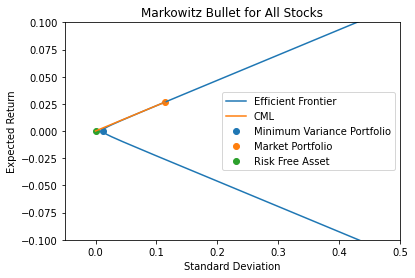



Tech Stocks MVP(σ, µ) = (0.015201853527881224, 0.00051247872050981)
Tech Stocks MP(σ, µ) = (0.06193866425932265, 0.008507587416824341)


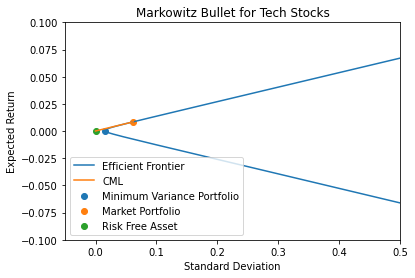



Bank Stocks MVP(σ, µ) = (0.01257036543615065, -7.771221462830913e-05)
Bank Stocks MP(σ, µ) = (0.3282355960281732, -0.0529864511483058)


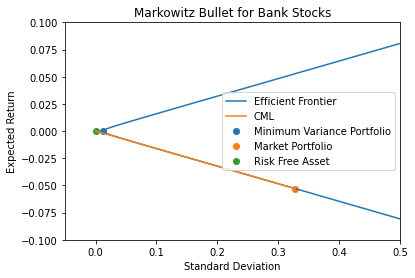

In [23]:
#1d.)

def get_MVP_and_MP(stocks, sector):
  ones = np.ones(len(stocks))
  mean = all_expected_returns_df[stocks].mean()
  cov = all_expected_returns_df[stocks].cov()
  cov_inv = np.linalg.inv(cov)

  sigma_MVP = 1/(np.sqrt(ones.T @ cov_inv @ ones))
  mu_MVP = (ones.T @ cov_inv @ mean)/(ones.T @ cov_inv @ ones)

  w_MP_s = 1/(ones @ cov_inv @ mean)
  w_MP = w_MP_s * cov_inv @ mean

  mu_MP = w_MP @ mean
  sigma_MP = np.sqrt(w_MP @ cov @ w_MP)

  print(sector + " MVP(σ, µ) = (" + str(sigma_MVP) + ", " + str(mu_MVP) + ")")
  print(sector + " MP(σ, µ) = (" + str(sigma_MP) + ", " + str(mu_MP) + ")")

  sigma_ef = []
  mu_ef = np.linspace(-0.5, 0.5, 2000)
  mu = all_expected_returns_df[stocks].mean()

  for i in mu_ef:
    mu_t = np.array([i, 1])
    m_t = np.concatenate((mu.values.reshape((len(stocks), 1)), np.ones((len(stocks), 1))), axis = 1)
    B = m_t.T @ cov_inv @ m_t
    B_inv = np.linalg.inv(B)
    sigma_v = np.sqrt(mu_t.T @ B_inv @ m_t.T @ cov_inv @ m_t @ B_inv @ mu_t)
    sigma_ef.append(sigma_v)

  risk_free_rate = fed_3mo_daily['3MO T-BILL'].iloc[1:].mean()

  plt.figure()
  plt.plot(sigma_ef, mu_ef, label = "Efficient Frontier")
  plt.plot([0, sigma_MP], [risk_free_rate, mu_MP], label = "CML")
  plt.scatter(sigma_MVP, mu_MVP, label = "Minimum Variance Portfolio")
  plt.scatter(sigma_MP, mu_MP, label = "Market Portfolio")
  plt.scatter(0, risk_free_rate, label = "Risk Free Asset")
  plt.legend()
  plt.axis([-0.05, 0.5, -0.1, 0.1])
  plt.title("Markowitz Bullet for " + sector)
  plt.xlabel("Standard Deviation")
  plt.ylabel("Expected Return") 
  plt.show()

  return mu_MP

all_mu_MP = get_MVP_and_MP(combined_stocks, "All Stocks")
print("\n")
tech_mu_MP = get_MVP_and_MP(tech_stocks, "Tech Stocks")
print("\n")
bank_mu_MP = get_MVP_and_MP(bank_stocks, "Bank Stocks")

In [24]:
#1e.)

print("""Looking at the Market Portfolio weights of all the graphs, there is significant short selling in all three cases. 
Viewing the graphs subjectively though, both the Market Portfolio weights for the All Stocks Plot and the Bank Stocks plot are
considerably farther than the S&P500, whereas the Market Portfolio weight is somewhat close to the S&P 500 relatively speaking.""")

Looking at the Market Portfolio weights of all the graphs, there is significant short selling in all three cases. 
Viewing the graphs subjectively though, both the Market Portfolio weights for the All Stocks Plot and the Bank Stocks plot are
considerably farther than the S&P500, whereas the Market Portfolio weight is somewhat close to the S&P 500 relatively speaking.


In [25]:
#1f.)

all_betas = pd.DataFrame()
tech_betas = pd.DataFrame()
bank_betas = pd.DataFrame()

for stock in combined_stocks:
  all_betas[stock] = [all_expected_returns_df[stock].mean()/all_mu_MP]

for tech_stock in tech_stocks:
  tech_betas[tech_stock] = [all_expected_returns_df[tech_stock].mean()/tech_mu_MP]

for bank_stock in bank_stocks:
  bank_betas[bank_stock] = [all_expected_returns_df[bank_stock].mean()/bank_mu_MP]

print("All stocks β values:")
display(all_betas)
print("\nTech stocks β values:")
display(tech_betas)
print("\nBank stocks β values:")
display(bank_betas)

All stocks β values:


,TWTR,AAPL,MSFT,AMZN,GOOG,JPM,BAC,WFC,MS,GS
0,0.061491,0.010861,0.046639,0.062591,0.007113,0.009039,-0.00512,-0.013532,-0.020391,-0.043633



Tech stocks β values:


,TWTR,AAPL,MSFT,AMZN,GOOG
0,0.19272,0.03404,0.146171,0.196167,0.022292



Bank stocks β values:


,JPM,BAC,WFC,MS,GS
0,-0.004549,0.002577,0.00681,0.010261,0.021957


Expected Daily Returns for All Stocks for January


,TWTR,AAPL,MSFT,AMZN,GOOG,JPM,BAC,WFC,MS,GS
DATE,,,,,,,,,,
2018-01-03,-0.002504,-0.000230,0.004598,0.012719,0.016357,0.000963,-0.003400,0.007638,0.002627,-0.009365
2018-01-04,-0.018870,0.004589,0.008745,0.004420,0.003565,0.014270,0.013031,0.012452,0.015232,0.013920
2018-01-05,0.013700,0.011329,0.012342,0.016107,0.014515,-0.006476,0.004581,0.006682,-0.000433,-0.005156
2018-01-08,0.011046,-0.003770,0.000964,0.014369,0.004217,0.001421,-0.006980,-0.011371,-0.004198,-0.014575
2018-01-09,-0.017136,-0.000171,-0.000736,0.004620,-0.000670,0.005013,0.004924,0.003490,0.007696,0.008403
2018-01-10,0.003254,-0.000285,-0.004590,0.001245,-0.003355,0.010948,0.009194,0.013757,0.011764,0.001480
2018-01-11,0.004068,0.005624,0.002905,0.017762,0.002583,0.005295,0.003545,-0.001799,0.004951,0.003090
2018-01-12,0.043476,0.010270,0.017201,0.022283,0.015086,0.016454,0.017230,-0.007356,0.016918,0.007391
2018-01-16,-0.029572,-0.005138,-0.014007,-0.000317,-0.000501,-0.003606,0.001547,-0.000855,-0.009490,0.005508




β values for All Stocks for the month of January


,TWTR,AAPL,MSFT,AMZN,GOOG,JPM,BAC,WFC,MS,GS
0,0.404586,0.321143,0.456874,0.131666,0.321463,0.170281,0.130607,0.172038,0.301763,-0.02024




Average Daily Returns for All Stocks and S&P500 for February


,TWTR,AAPL,MSFT,AMZN,GOOG,JPM,BAC,WFC,MS,GS,^GSPC
0,0.011956,0.003662,-0.000231,0.002401,-0.002766,0.000076,0.000338,-0.005642,-0.000275,-0.000627,-0.00201


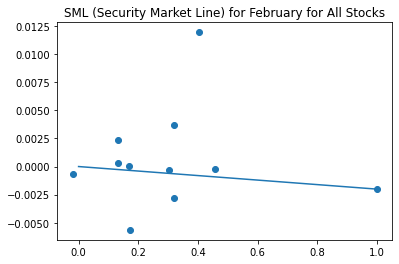



Expected Daily Returns for Tech Stocks for January


,TWTR,AAPL,MSFT,AMZN,GOOG
DATE,,,,,
2018-01-03,-0.002504,-0.000230,0.004598,0.012719,0.016357
2018-01-04,-0.018870,0.004589,0.008745,0.004420,0.003565
2018-01-05,0.013700,0.011329,0.012342,0.016107,0.014515
2018-01-08,0.011046,-0.003770,0.000964,0.014369,0.004217
2018-01-09,-0.017136,-0.000171,-0.000736,0.004620,-0.000670
2018-01-10,0.003254,-0.000285,-0.004590,0.001245,-0.003355
2018-01-11,0.004068,0.005624,0.002905,0.017762,0.002583
2018-01-12,0.043476,0.010270,0.017201,0.022283,0.015086
2018-01-16,-0.029572,-0.005138,-0.014007,-0.000317,-0.000501




β values for Tech Stocks for the month of January


,TWTR,AAPL,MSFT,AMZN,GOOG
0,0.404586,0.321143,0.456874,0.131666,0.321463




Average Daily Returns for Tech Stocks and S&P500 for February


,TWTR,AAPL,MSFT,AMZN,GOOG,^GSPC
0,0.011956,0.003662,-0.000231,0.002401,-0.002766,-0.00201


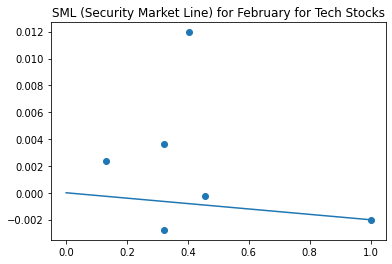



Expected Daily Returns for Bank Stocks for January


,JPM,BAC,WFC,MS,GS
DATE,,,,,
2018-01-03,0.000963,-0.003400,0.007638,0.002627,-0.009365
2018-01-04,0.014270,0.013031,0.012452,0.015232,0.013920
2018-01-05,-0.006476,0.004581,0.006682,-0.000433,-0.005156
2018-01-08,0.001421,-0.006980,-0.011371,-0.004198,-0.014575
2018-01-09,0.005013,0.004924,0.003490,0.007696,0.008403
2018-01-10,0.010948,0.009194,0.013757,0.011764,0.001480
2018-01-11,0.005295,0.003545,-0.001799,0.004951,0.003090
2018-01-12,0.016454,0.017230,-0.007356,0.016918,0.007391
2018-01-16,-0.003606,0.001547,-0.000855,-0.009490,0.005508




β values for Bank Stocks for the month of January


,JPM,BAC,WFC,MS,GS
0,0.170281,0.130607,0.172038,0.301763,-0.02024




Average Daily Returns for Bank Stocks and S&P500 for February


,JPM,BAC,WFC,MS,GS,^GSPC
0,0.000076,0.000338,-0.005642,-0.000275,-0.000627,-0.00201


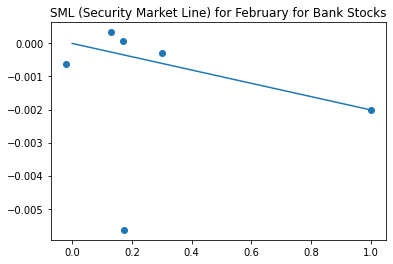

In [26]:
def get_SML(stocks, sector):

  if (SP500 not in stocks):
    stocks.append(SP500)

  january_expected_returns = pd.DataFrame()
  january_betas = pd.DataFrame()

  for stock in stocks[:-1]:
    january_expected_returns[stock] = all_expected_returns_df[stock].iloc[0: 20]
    january_betas[stock] = [january_expected_returns[stock].cov(all_expected_returns_df[SP500])]/all_expected_returns_df[SP500].var()

  print("Expected Daily Returns for " + sector + " Stocks for January")
  display(january_expected_returns)
  print("\n")
  print("β values for " + sector + " Stocks for the month of January")
  display(january_betas)
  print("\n")

  january_betas[SP500] = 1
  february_average_returns = pd.DataFrame()

  for stock in stocks:
    february_average_returns[stock] = [all_expected_returns_df[stock].iloc[20: 39].mean()]

  print("Average Daily Returns for " + sector + " Stocks and S&P500 for February")
  display(february_average_returns)
  print("\n")

  plt.figure()
  plt.scatter(january_betas, february_average_returns)
  plt.plot(np.array([0, 1], dtype = object), np.array([0, february_average_returns[SP500]], dtype = object))
  plt.title("SML (Security Market Line) for February for " + sector +" Stocks")
  plt.show()

get_SML(combined_stocks, "All")
print("\n")
get_SML(tech_stocks, "Tech")
print("\n")
get_SML(bank_stocks, "Bank")

Annual Closing Prices:
All Stocks: 1.030415068030039
Tech Stocks: 1.0091634207822244
Bank Stocks: 1.0167840696111226
S&P 500: 1.0108275282300818




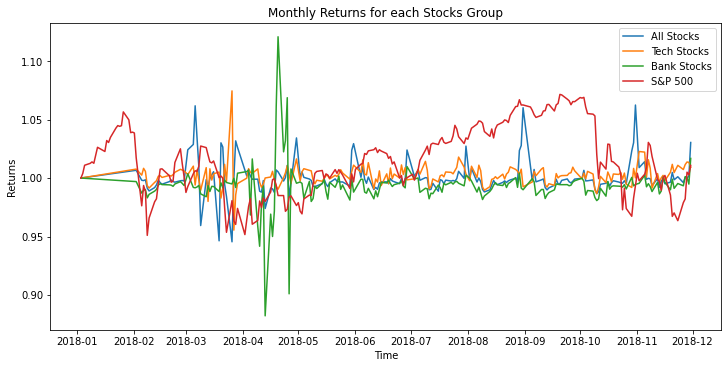

In [31]:
def get_mp(stocks):

  returns = pd.DataFrame(columns = ['day', 'amount'])
  returns = returns.append({'day':all_expected_returns_df.index[0], 'amount': 1}, ignore_index = True)

  for i in range(1, 12):
    month = str(i)
    if i < 10:
      month = '0' + month

    ones = np.ones(len(stocks))
    mean = all_expected_returns_df[stocks]['2018-'+ month : '2018-'+ month].mean()
    cov = all_expected_returns_df[stocks]['2018-'+ month : '2018-'+ month].cov()
    cov_inv = np.linalg.inv(cov)

    w_MP_s = 1/(ones @ cov_inv @ mean)
    w_MP = w_MP_s * cov_inv @ mean

    next_month = str(i + 1)
    if i < 9:
      next_month = '0' + next_month

    portfolio = pd.DataFrame()
    for i, stock in enumerate(stocks):
      portfolio[stock] = w_MP[i] * all_expected_returns_df[stock]['2018-'+ next_month : '2018-'+ next_month]
        
    monthly_expected_returns = portfolio.mean(1)

    for i in range(1, len(monthly_expected_returns)):
      returns = returns.append({'day':monthly_expected_returns.index[i], 'amount': returns['amount'][i - 1] + monthly_expected_returns[i]}, ignore_index = True)
    
  return returns

sp_returns = pd.DataFrame(columns = ['day', 'amount'])
sp_returns = sp_returns.append({'day':all_expected_returns_df.index[0], 'amount': 1}, ignore_index = True)

for i in range(1, len(all_expected_returns_df[SP500])):
  sp_returns = sp_returns.append({'day':all_expected_returns_df.index[i], 'amount': sp_returns['amount'][i - 1] + all_expected_returns_df[SP500][i]}, ignore_index = True)

all_returns = get_mp(combined_stocks)
tech_returns = get_mp(tech_stocks)
bank_returns = get_mp(bank_stocks)

print("Annual Closing Prices:")
print("All Stocks: " + str(all_returns['amount'].tail(1).values[0]))
print("Tech Stocks: " + str(tech_returns['amount'].tail(1).values[0]))
print("Bank Stocks: " + str(bank_returns['amount'].tail(1).values[0]))
print("S&P 500: " + str(sp_returns['amount'].tail(1).values[0]))
print("\n")

fig, ax = plt.subplots(1, 1, constrained_layout = True, figsize = (10, 5))
ax.plot(all_returns['day'], all_returns['amount'])
ax.plot(tech_returns['day'], tech_returns['amount'])
ax.plot(bank_returns['day'], bank_returns['amount'])
ax.plot(sp_returns['day'], sp_returns['amount'])
ax.set_title("Monthly Returns for each Stocks Group")
ax.set_xlabel("Time")
ax.set_ylabel("Returns")
ax.legend(["All Stocks", "Tech Stocks", "Bank Stocks", "S&P 500"])

fig.show()